In [3]:
import pandas as pd
from pathlib import Path
from shutil import copy

In [10]:
#Import and add "gr" variable
t1 = pd.read_csv('cat19.csv')

t1['gr'] = t1['g_cmodel_mag'] - t1['r_cmodel_mag']

print(t1.head()['gr'])

0    0.973304
1    0.413082
2    0.882370
3    0.981340
4    1.191181
Name: gr, dtype: float64


In [25]:
#Filter dataframe down to 1000 samples that are 99% predicted to be oval1 and most likely red
t1_filtered = t1[(t1['oval1'] > 0.99) & (t1['gr'] > 0.75)].sample(n=1000)

In [26]:
#Create temp folder for red ovals
source_folder = Path('ims')
dest_folder = Path('tmp_red')
dest_folder.mkdir(exist_ok=True)

In [27]:
#Copy images to folder
for image_id in t1_filtered['Unnamed: 0']:
    src_file = source_folder / f"{image_id}.png"
    dst_file = dest_folder / f"{image_id}.png"
    if src_file.exists():
        copy(src_file, dst_file)
    else:
        print(f"Image {src_file} not found.")

In [ ]:
#Repeat above process for blue ovals (condensed to one cell)

#Filter dataframe down to 1000 samples that are 99% predicted to be oval1 and most likely blue
t1_filtered = t1[(t1['oval1'] > 0.99) & (t1['gr'] < 0.55)].sample(n=1000)

#Create temp folder for blue ovals
source_folder = Path('ims')
dest_folder = Path('tmp_blue')
dest_folder.mkdir(exist_ok=True)

#Copy images to folder
for image_id in t1_filtered['Unnamed: 0']:
    src_file = source_folder / f"{image_id}.png"
    dst_file = dest_folder / f"{image_id}.png"
    if src_file.exists():
        copy(src_file, dst_file)
    else:
        print(f"Image {src_file} not found.")

# Create classifier using fast.ai

In [37]:
from fastai.vision.all import *
from sklearn.model_selection import train_test_split

In [39]:
#Split test and train data randomly for red and blue ovals
source_folder = Path('ims')
classes = ['xblue', 'xred']

for cls in classes:
    img_path = source_folder / cls
    images = list(img_path.iterdir())
    
    # Split into train and valid
    train_imgs, valid_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create target folders
    (source_folder / 'train' / cls).mkdir(parents=True, exist_ok=True)
    (source_folder / 'valid' / cls).mkdir(parents=True, exist_ok=True)

    # Move images
    for img in train_imgs:
        shutil.move(str(img), str(source_folder / 'train' / cls / img.name))
    for img in valid_imgs:
        shutil.move(str(img), str(source_folder / 'valid' / cls / img.name))



In [41]:
#Load tested data
dls = ImageDataLoaders.from_folder(source_folder, train='train', vald='valid') #, item_tfms=Resize(224))

#Create model
learn = vision_learner(dls, resnet34, metrics=accuracy)
#Fine tune
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\evnpu/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:03<00:00, 24.1MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.552073,0.184825,0.929167,02:56


epoch,train_loss,valid_loss,accuracy,time
0,0.147805,0.198226,0.955208,03:23
1,0.080024,0.088743,0.976042,03:24
2,0.034598,0.080395,0.980208,03:24
3,0.015589,0.083839,0.980208,03:23


In [42]:
#Evaluate
learn.validate()

(#2) [0.08383893966674805,0.9802083373069763]

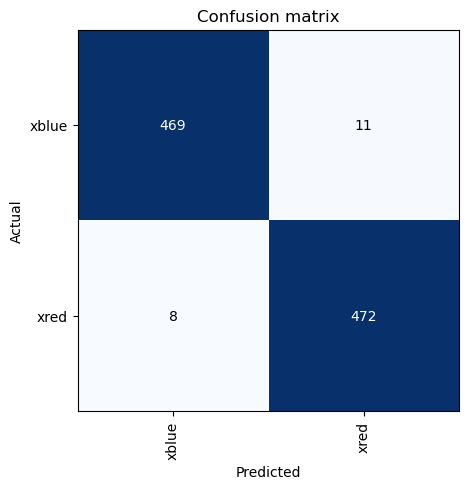

In [43]:
#Evaluate model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [44]:
#Save classifier
learn.export('oval_model1.pkl')